<a href="https://colab.research.google.com/github/akshatgoel92/intro-dl-2/blob/master/src/3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Mount Google Drive so we can access data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Install idx2numpy package for extracting data
!pip install idx2numpy

  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-cp36-none-any.whl size=7907 sha256=b8fd6773b17d6b2134682406c560b3f2135c2243463a1dcb1a06bc5ad404b466
  Stored in directory: /root/.cache/pip/wheels/7a/c1/da/284ce80a748fab898b8d1fa95468a386e7cf3b81da18511f9d
Successfully built idx2numpy


In [5]:
# Import packages
import os
import json
import gzip
import torch
import torchvision
import numpy as np 
import pandas as pd
import pprint

import idx2numpy
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as transforms
import torchvision.transforms as trans
import matplotlib.pyplot as plt

from collections import OrderedDict 

In [6]:
def get_best_results(results):
  '''
  Take in a results dictionary 
  and return epoch on which 
  minimum validation loss was
  reached, minimum val. loss on
  that epoch, and min. accuracy
  on that epoch
  '''
  # Find the epoch on which the minimum validation loss was reached
  best_val_epoch = np.argmin(np.array(results['val_loss']))
  
  # Store validation metrics
  best_epoch_val_loss = np.array(results['val_loss'][best_val_epoch])

  # Store training metrics
  best_epoch_train_loss = np.array(results['train_loss'][best_val_epoch])
  
  # Store best results in a list
  best_results = [np.int(best_val_epoch), 
                  np.float(best_epoch_val_loss),
                  np.float(best_epoch_train_loss)]

  # Return statement
  return(best_results)


def plot_loss(results, lab, model_num):
  '''
  Convenience function to plot results
  '''
  # Store model name and destination path
  model_name = str(model_num) + '_' + lab + '_results.png'
  path = os.path.join('/content/drive/MyDrive/', '2_figs', model_name)
  
  # Plot the results
  plt.plot(results['train_' + lab], label='Train')
  plt.plot(results['val_' + lab], label='Validation')
  
  # Add annotations
  plt.legend()
  plt.title(lab.title() + ' by Epoch')
  
  # Save the figure and close the plot
  plt.savefig(path)
  plt.clf()

In [7]:
def load_one_dataset(path):
    '''
    Convenience function to load a single dataset
    '''
    f = gzip.open(path, 'rb')
    data = torch.from_numpy(idx2numpy.convert_from_file(f).astype('float64'))
    f.close()
    
    return(data)


def load_all_datasets(train_imgs, train_labs, test_imgs, test_labs, batch_size):
    '''
    Load training as well as test images here
    '''
    train_images = load_one_dataset(train_imgs).type(torch.float32)/255.0
    train_labels = load_one_dataset(train_labs).type(torch.long)
    train = list(zip(train_images, train_labels))

    test_images = load_one_dataset(test_imgs).type(torch.float32)/255.0
    test_labels = load_one_dataset(test_labs).type(torch.long)
    test = list(zip(test_images, test_labels))
    
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False, num_workers=2)
    
    return(train_loader, test_loader)

In [8]:
def add_noise(img, quadrants):
  '''
  Randomly remove 1 or 2 quadrants
  from the input image.
  '''
  # Get the number of quadrants to erase
  n_quads_to_erase = np.random.choice([1, 2])

  # Get which quadrants to erase
  quads_to_erase = np.random.choice([1, 2, 3, 4], size = n_quads_to_erase)

  # Create a copy of the image
  noisy_img = img.clone()

  # Now erase the quadrants
  for quad in quads_to_erase:
    noisy_img = transforms.erase(noisy_img, *quadrants[quad])
  
  # Return statement
  return(noisy_img)

In [18]:
def plot_image(plot_noise, plot_preds, plot_clean):
  '''
  Take an image stored as a Torch
  tensor and display it in the notebook
  '''
  # plt.figure(figsize=(20,10))
  # columns = 5
  
  # for i, img in enumerate(imgs):
  #   plt.subplot(len(imgs) / columns + 1, columns, i + 1)
  #   plt.imshow(img.cpu().numpy().reshape(28,28))

  

  quadrants = {
    1: [0, 0, 14, 14, 0], 
    2: [0, 14, 14, 14, 0],
    3: [14, 0, 14, 14, 0],
    4: [14, 14, 14, 14, 0],
  }

  a = 0
  for j in range(4):
    n = 8
    plt.figure(figsize=(20, 8))

    for i in range(n):
      # get one image from the batch
      # img = images[i]#np.squeeze(images[j])

      # display original
      ax = plt.subplot(3, n, i + 1)
      img = plot_clean[a]
      ax.imshow(img.cpu().numpy().reshape(28,28))
      plt.title("original")
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      # display noisy images
      ax = plt.subplot(3, n, i + 1 + n)
      # Get noisy image
      # noisy_img = add_noise(plot_noise[i], quadrants)
      ax.imshow(plot_noise[a].cpu().numpy().reshape(28,28))
      plt.title("noised")
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      # display reconstructed images
      ax = plt.subplot(3, n, i + 1 + n*2)
      recon_img = plot_preds[a]
      ax.imshow(recon_img.cpu().numpy().reshape(28,28))
      plt.title("reconstructed")
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      a+= 1

In [10]:
def test_noise():
  '''
  Test the noise function
  '''
  # Just for testing out noise function
  data_dir = '/content/drive/MyDrive/data'

  # Set paths
  paths = {
        'train_imgs': os.path.join(data_dir, 'train-images-idx3-ubyte.gz'),
        'train_labs': os.path.join(data_dir, 'train-labels-idx1-ubyte.gz'),
        'test_imgs': os.path.join(data_dir,'t10k-images-idx3-ubyte.gz'),
        'test_labs': os.path.join(data_dir,'t10k-labels-idx1-ubyte.gz')
  }

  # Load datasets
  train_loader, test_loader = load_all_datasets(**paths, batch_size = 32)

  # Get the next batch from the train loader
  images, labels = iter(train_loader).next()

  # Store the quadrant definitions: move this into training loop later
  quadrants = {
      
      1: [0, 0, 14, 14, 0], 
      2: [0, 14, 14, 14, 0],
      3: [14, 0, 14, 14, 0],
      4: [14, 14, 14, 14, 0],
  }

  # Take the first image in the batch
  img = images[0]

  # Get noisy image
  noisy_img = add_noise(img, quadrants)

  #plot_image(noisy_img)

  # Return statement
  return(img, noisy_img)

In [11]:
class DenoisingAutoencoder(nn.Module):
  
  def __init__(self, encoder_units, decoder_units, input_dim, output_dim):
    
    # Conventional super-class declaration
    super(DenoisingAutoencoder, self).__init__()

    # Initialize lists to store layers
    encoder = []
    decoder = []

    # Add input and output dimensions to layer list for encoder
    self.encoder_units = [input_dim] + encoder_units
    self.decoder_units = [encoder_units[-1]] + decoder_units + [output_dim]

    # Compute the total no. of layers for the encoder/decoder
    self.encoder_layers = len(self.encoder_units)
    self.decoder_layers = len(self.decoder_units)

    # Append the hidden layers for the encoder
    for i in range(1, self.encoder_layers):
      
      # Add linear layer
      layer = ('Linear{}'.format(i), nn.Linear(self.encoder_units[i-1], self.encoder_units[i]))
      activation = ('RELU{}'.format(i), nn.ReLU(True))
      
      # Append
      encoder.append(layer)
      encoder.append(activation)
    
    # Append the hidden layers for the decoder
    for i in range(1, self.decoder_layers - 1):
      
      # Add the layers
      layer = ('Linear{}'.format(i), nn.Linear(self.decoder_units[i-1], self.decoder_units[i]))
      activation = ('RELU{}'.format(i), nn.ReLU(True))
      
      # Append to the lists
      decoder.append(layer)
      decoder.append(activation)

    # Create final output layer
    i = self.decoder_layers - 1
    layer = ('Linear{}'.format(i), nn.Linear(self.decoder_units[i-1], self.decoder_units[i]))
    activation = ('Sigmoid{}'.format(i), nn.Sigmoid())
    
    # Append to decoder list
    decoder.append(layer)
    decoder.append(activation)
    
    # Wrap this in a container and declare the encoder/decoder
    self.encoder = nn.Sequential(OrderedDict(encoder))
    self.decoder = nn.Sequential(OrderedDict(decoder))
    
  def forward(self, x):
    
    # First encode the noisy image and then decode
    x=self.encoder(x)
    x=self.decoder(x)
    
    return x

In [12]:
def train(config,
          epochs=2, 
          input_dim = 784, output_dim = 784, 
          data_dir = '/content/drive/MyDrive/data'):
    '''
    This is the main training loop
    '''
    # Set the seed so each experiment is reproducible
    np.random.seed(21390)
    torch.manual_seed(10394)

    # Set device
    if torch.cuda.is_available():
      device = torch.device("cuda")
    else:
      device = torch.device("cpu")
    
    # Set paths to datasets
    paths = {
        'train_imgs': os.path.join(data_dir, 'train-images-idx3-ubyte.gz'),
        'train_labs': os.path.join(data_dir, 'train-labels-idx1-ubyte.gz'),
        'test_imgs': os.path.join(data_dir,'t10k-images-idx3-ubyte.gz'),
        'test_labs': os.path.join(data_dir,'t10k-labels-idx1-ubyte.gz')
    }

    #------------------------------------------------------------------------------------------------------

    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    # initialize the early_stopping object
    #early_stopping = EarlyStopping(patience=patience, verbose=True)

    # for epoch in range(1, n_epochs + 1):

    #     ###################
    #     # train the model #
    #     ###################
    #     model.train() # prep model for training
    #     for batch, (data, target) in enumerate(train_loader, 1):
    #         # clear the gradients of all optimized variables
    #         optimizer.zero_grad()
    #         # forward pass: compute predicted outputs by passing inputs to the model
    #         output = model(data)
    #         # calculate the loss
    #         loss = criterion(output, target)
    #         # backward pass: compute gradient of the loss with respect to model parameters
    #         loss.backward()
    #         # perform a single optimization step (parameter update)
    #         optimizer.step()
    #         # record training loss
    #         train_losses.append(loss.item())

    #     ######################    
    #     # validate the model #
    #     ######################
    #     model.eval() # prep model for evaluation
    #     for data, target in valid_loader:
    #         # forward pass: compute predicted outputs by passing inputs to the model
    #         output = model(data)
    #         # calculate the loss
    #         loss = criterion(output, target)
    #         # record validation loss
    #         valid_losses.append(loss.item())

    #     # print training/validation statistics 
    #     # calculate average loss over an epoch
    #     train_loss = np.average(train_losses)
    #     valid_loss = np.average(valid_losses)
    #     avg_train_losses.append(train_loss)
    #     avg_valid_losses.append(valid_loss)
        
    #     epoch_len = len(str(n_epochs))
        
    #     print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
    #                  f'train_loss: {train_loss:.5f} ' +
    #                  f'valid_loss: {valid_loss:.5f}')
        
    #     print(print_msg)
        
    #     # clear lists to track next epoch
    #     train_losses = []
    #     valid_losses = []
        
    #     # early_stopping needs the validation loss to check if it has decresed, 
    #     # and if it has, it will make a checkpoint of the current model
    #     early_stopping(valid_loss, model)
        
    #     if early_stopping.early_stop:
    #         print("Early stopping")
    #         break
        
    # # load the last checkpoint with the best model
    # model.load_state_dict(torch.load('checkpoint.pt'))

    # return  model, avg_train_losses, avg_valid_losses 

    #------------------------------------------------------------------------------------------------------

    # Store the quadrant definitions: move this into training loop later
    quadrants = {
      
      1: [0, 0, 14, 14, 0], 
      2: [0, 14, 14, 14, 0],
      3: [14, 0, 14, 14, 0],
      4: [14, 14, 14, 14, 0],
    }

    # Load datasets
    train_loader, test_loader = load_all_datasets(**paths, batch_size = config['batch_size'])

    
    # Set parameters
    net = DenoisingAutoencoder(config['encoder_units'], config['decoder_units'], input_dim, output_dim)
    
    # Send net object to device memory
    net.to(device)
    
    # We use the cross-entropy loss
    criterion = nn.MSELoss()

    # We use mini-batch stochastic gradient descent with momentum
    optimizer = optim.SGD(net.parameters(), lr=config['lr'], momentum=config['momentum'], 
                                            weight_decay=config['weight_decay'])

    # Store results here
    results = {
      'train_loss': [], 
      'val_loss': [], 
      }

    # Loop over the dataset multiple times
    for epoch in range(epochs):  
        
        # Initialize running loss
        running_loss = 0.0
        running_accuracy = 0.0

        # Initialize the validation running loss
        val_running_loss = 0.0
        val_running_accuracy = 0.0

        plot_noise = []
        plot_preds = []
        plot_clean = []
        
        # Iterate through data now
        for i, data in enumerate(train_loader):
            
            # Get the inputs: data is a list of [inputs, labels]
            clean_images, _ = data
            
            # Initialize container for noisy images
            noisy_images = []

            # Now get noisy images
            for img in clean_images: 
              noisy_images.append(add_noise(img, quadrants))
            
            # Convert noisy image list to Torch tensor
            noisy_images = torch.stack(noisy_images, dim =0)
            
            # Flatten noisy images
            noisy_images=noisy_images.view(noisy_images.size(0),-1).type(torch.FloatTensor)
            
            # Flatten clean images
            flat_clean_imgs = clean_images.view(clean_images.size(0),-1).type(torch.FloatTensor)

            # Send the inputs and labels to the memory of the device
            noisy_images, flat_clean_imgs = noisy_images.to(device), flat_clean_imgs.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            pred_images = net(noisy_images)

            # Calculate loss
            loss = criterion(pred_images, flat_clean_imgs)

            # Backward
            loss.backward()
            
            # Optimize
            optimizer.step()

            # Add to running loss
            running_loss += loss.item()
        
        # Loop through the validation data
        for j, data in enumerate(test_loader):
          
          # No need to calculate gradients for validation set
          with torch.no_grad():

              # Get the inputs: data is a list of [inputs, labels]
              val_clean_images, _ = data
            
              # Initialize container for noisy images
              val_noisy_images = []

              # Now get noisy images
              # Flatten clean images for loss calculation
              for img in val_clean_images: 
                val_noisy_images.append(add_noise(img, quadrants))
            
              # Convert noisy image list to Torch tensor
              # Flatten noisy validation images
              val_noisy_images = torch.stack(val_noisy_images, dim =0)
              val_noisy_images=val_noisy_images.view(val_noisy_images.size(0),-1).type(torch.FloatTensor)
              
              # Flatten clean validation images
              val_flat_clean_imgs = val_clean_images.view(val_clean_images.size(0),-1).type(torch.FloatTensor)

              # Send the inputs and labels to the memory of the device
              val_noisy_images, val_flat_clean_imgs = val_noisy_images.to(device), val_flat_clean_imgs.to(device)

              # Send the data item through the network to get output
              val_pred_images = net(val_noisy_images)

              # Plot images
              noise_check = val_noisy_images[0]
              pred_check = val_pred_images[0]
              clean_check = val_flat_clean_imgs[0]
              
              plot_noise.append(noise_check)
              plot_preds.append(pred_check)
              plot_clean.append(clean_check)

              # Compute the loss
              # Add to running loss
              val_loss = criterion(val_pred_images, val_flat_clean_imgs)
              val_running_loss += val_loss.item()
        
        # Rescale the training and validation perfomance metrics
        running_loss = (running_loss)/len(train_loader)
        
        # Rescale the validation loss
        val_running_loss = (val_running_loss)/len(test_loader)
        
        # Append to the results tracker
        results['train_loss'].append(np.float(running_loss))
        results['val_loss'].append(np.float(val_running_loss))

        # Make print message format string
        msg = "Epoch:{} | Training Loss:{} | Validation Loss: {}" "\n"

        # Print performance
        print(msg.format(epoch, running_loss, val_running_loss))
        
    # Print message
    print('Done training...')

    # Get the best results and print
    best_results = get_best_results(results)
    print(best_results)
    
    # Plot the losses
    plot_loss(results, lab='loss', model_num=config['model_num'])
    
    # Return statement
    return(results, best_results, plot_noise, plot_preds, plot_clean)

In [19]:
# Test configuration
test_config = {'lr': 0.7,
               'batch_size': 64,
               'weight_decay': 0.0,
               'encoder_units': [512, 256, 128, 64],
               'decoder_units': list(reversed([512, 256, 128, 64])),
               'momentum': 0.99,
               'done': 0,
               'model_num': 1}


# Try out the test configuration
_, _, plot_noise, plot_preds, plot_clean = train(test_config, epochs = 5)

Epoch:0 | Training Loss:0.07420310115556854 | Validation Loss: 0.048640049495704614

Epoch:1 | Training Loss:0.03975419658047558 | Validation Loss: 0.033892688193138995

Epoch:2 | Training Loss:0.03267972993412252 | Validation Loss: 0.03137076756424585

Epoch:3 | Training Loss:0.029368808796839802 | Validation Loss: 0.028392602909047892

Epoch:4 | Training Loss:0.027750221664892202 | Validation Loss: 0.02824113542914011

Done training...
[4, 0.02824113542914011, 0.027750221664892202]


<Figure size 432x288 with 0 Axes>

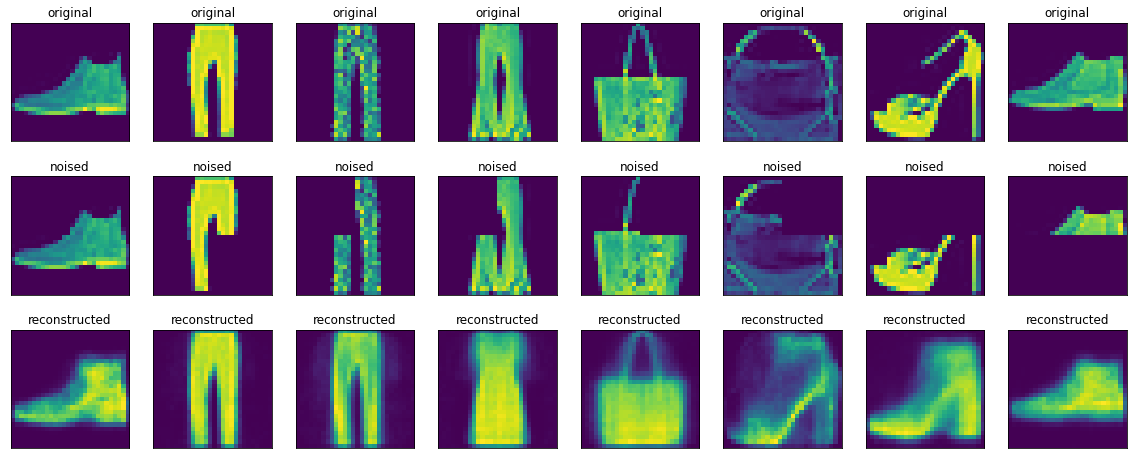

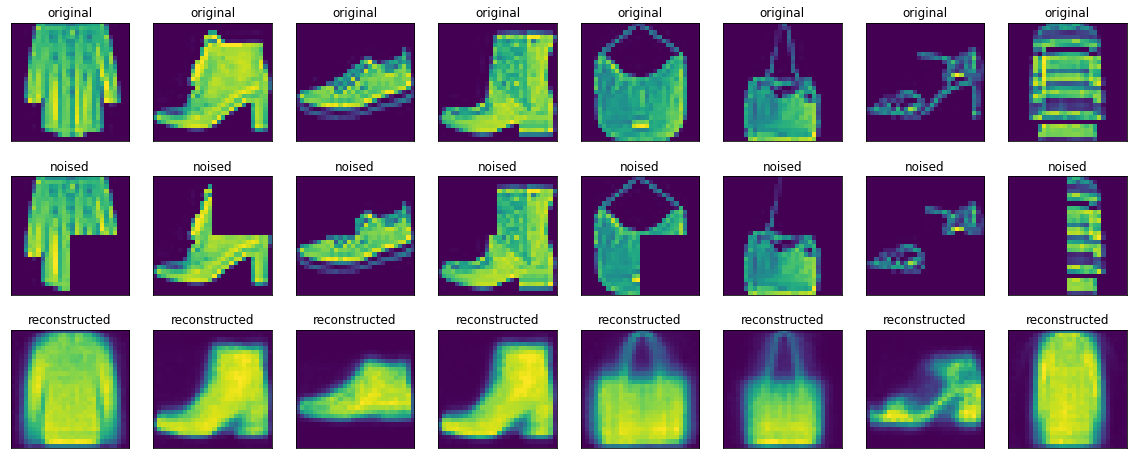

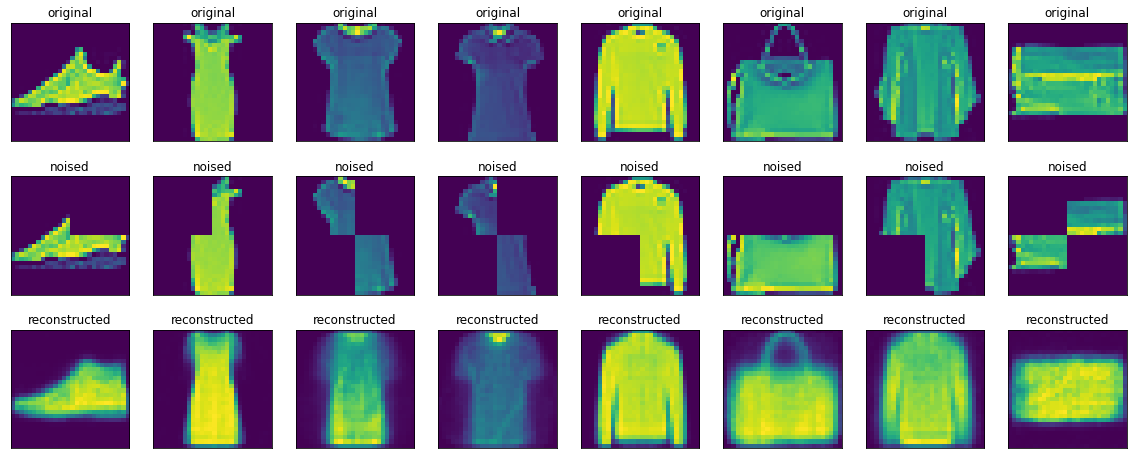

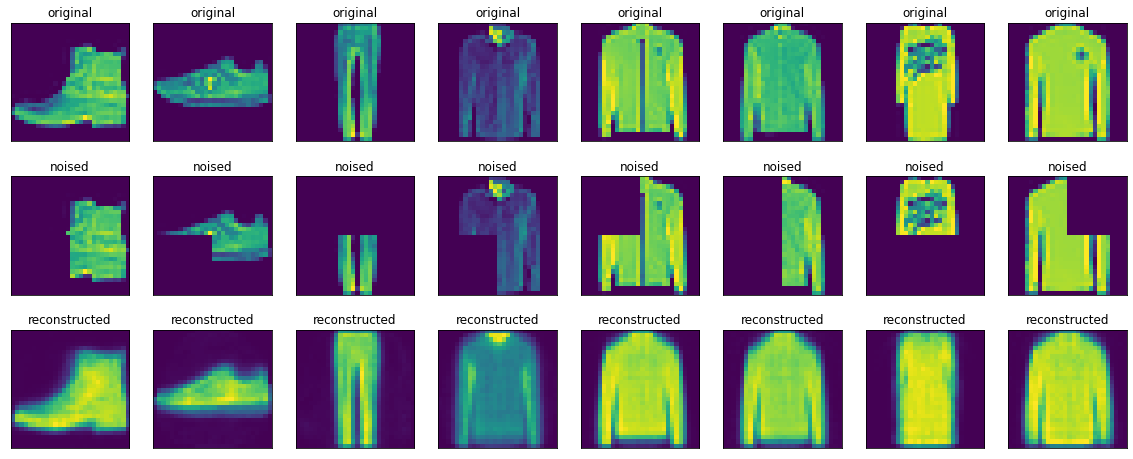

In [20]:
 # plot_noise
plot_image(plot_noise, plot_preds, plot_clean)

In [13]:
def store_best_parameters(experiment_id, checkpoints_dir = "/content/drive/MyDrive/2_checkpoints"):

  path_to_results = os.path.join(checkpoints_dir, str(experiment_id))

  # Load the experiment data file
  with open(path_to_results, 'r', encoding='utf-8') as f:
    experiment = json.load(f)

  #pprint.pprint(experiment, width=100)

  results_dir = "/content/drive/MyDrive/2_results"
  # This is the experiment path
  # path_to_save = os.path.join(results_dir, 'best_hyperparameters')

  # Load the experiment data file
  # with open(path_to_save, 'r', encoding='utf-8') as f:
  #   result = json.load(f)

  # result['best_results'].pop()
  # pprint.pprint(result, width=100)

  results = {
    'best_hyperparams': []
  }

  # # Create experiment ID
  # experiment_id = len([name for name in os.listdir(save_dir) if os.path.isfile(os.path.join(save_dir, name))]) + 1
  # print(experiment_id)

  # Loop through experiments data file
  for i, config in enumerate(experiment['best_results']):

    mini_val_loss = float('inf')
    mini_epochs = None
    mini_ind = None
    if config[1] < mini_val_loss:
      # save the result with parameters
      mini_ind = i
      mini_epochs = config[0]
      mini_val_loss = config[1]

  temp = experiment['params'][mini_ind]
  temp['best_val_loss'] = mini_val_loss
  temp['epochs'] = mini_epochs
  results['best_hyperparams'].append(temp)

  # This is the experiment path
  path = os.path.join(results_dir, str(experiment_id))

  # compare with the previously obtained validation loss
  if experiment_id > 1:
    path_to_prev = os.path.join(results_dir, str(experiment_id-1))

    # Load the experiment data file
    with open(path_to_prev, 'r', encoding='utf-8') as f:
      prev = json.load(f)

    prev_val_loss = prev['best_hyperparams'][0][0][0]['best_val_loss']

    if prev_val_loss < mini_val_loss:
      results['best_hyperparams'] = [prev['best_hyperparams']]

  # We write the experiment dictionary as a .json file
  with open(path, 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=4)

  # pprint.pprint(result, width=100)

  # plot_image(experiment['best_results'][0]['plot_noise'], experiment['best_results'][0]['plot_preds'], experiment['best_results'][0]['plot_clean'])
  _, _, plot_noise, plot_preds, plot_clean = train(temp, epochs = 20)
  plot_image(plot_noise, plot_preds, plot_clean)

In [14]:
def get_grid(archs, learning_rates, decays, momentums, batch_size = 64,
             checkpoints_dir = "/content/drive/MyDrive/2_checkpoints"):
  '''
  Get a random set of hyper-parameter combinations
  to test with for a given number of layers. 
  '''
  
  # Store the grid and results in this dictionary
  experiment = {
      
      'params': [], 
      'best_results': []

  }

  # Create experiment ID
  experiment_id = len([name for name in os.listdir(checkpoints_dir) if os.path.isfile(os.path.join(checkpoints_dir, name))]) + 1
  print(experiment_id)

  # This will generate the list of parameter combinations to search
  i = 0
  for arch in archs:
    for lr in learning_rates: 
      for d in decays: 
        for m in momentums:   
          config = {
                    'lr': lr,
                    'batch_size': batch_size,
                    'weight_decay': d,
                    'encoder_units': arch,
                    'decoder_units': list(reversed(arch)),
                    'momentum': m,
                    'done': 0,
                    'model_num': i}
          i += 1
          experiment['params'].append(config)

  # This is the experiment path
  path = os.path.join(checkpoints_dir, str(experiment_id))

  # We write the experiment dictionary as a .json file
  with open(path, 'w', encoding='utf-8') as f:
    json.dump(experiment, f, ensure_ascii=False, indent=4)

In [25]:
encoder_archs = [[512, 256, 128, 64, 32, 16], 
           [512, 256, 128, 64, 32], 
           [512, 256, 128, 64],
           [512, 256, 128],
           [512, 256],
           [256, 128, 64, 32, 16], 
           [256, 128, 64, 32],
           [256, 128, 64], 
           [256, 128],
           [128, 64, 32, 16], 
           [128, 64, 32],
           [64, 32, 16], 
           [64, 32], 
           [32, 16],
           [32]]

# 15-20
archs = [[16], [32], [50], [64], [100], [128], [150], [200], [256], [300], [350], [400], [450], [512], [550], [600]]

# decoder_archs = [[512, 256, 128, 64, 32, 16], 
#            [512, 256, 128, 64, 32], 
#            [512, 256, 128, 64],
#            [512, 256, 128],
#            [512, 256],
#            [256, 128, 64, 32, 16], 
#            [256, 128, 64, 32],
#            [256, 128, 64], 
#            [256, 128],
#            [128, 64, 32, 16], 
#            [128, 64, 32],
#            [64, 32, 16], 
#            [64, 32], 
#            [32, 16],
#            [32]]

r = np.arange(1e-4, 1e-2, 0.00055).tolist()
r.append(1e-2)

learning_rates = [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
decays = r #[0] #[0, 0.001, 0.01, 0.1]
momentums = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# batch_sizes = [32, 64, 128, 256, ....]

get_grid([[550]], [0.9], [0], [0.9], batch_size = 16, checkpoints_dir = "/content/drive/MyDrive/2_checkpoints")

10


In [15]:
def run_grid_search(experiment_id, checkpoints_dir = "/content/drive/MyDrive/2_checkpoints"):
  '''
  Run the grid search
  '''
  # First we load the experiment dictionary
  # Create the complete path
  path = os.path.join(checkpoints_dir, str(experiment_id))
  
  # Load the experiment data file
  with open(path, 'r', encoding='utf-8') as f:
    experiment = json.load(f)

  # Loop through experiments data file
  for i, config in enumerate(experiment['params']):
    
    # Print progress report
    print("This is combination {} of experiment {}".format(i, experiment_id))

    # Run experiments only for those parameter combinations which have not been tested
    if config['done'] == 0:
      print(config)
      results, best_results, plot_noise, plot_preds, plot_clean = train(config, epochs=70)
      experiment['best_results'].append(best_results)
      # experiment['best_results'][0]['plot_noise'] = plot_noise[:9]
      # experiment['best_results'][0]['plot_preds'] = plot_preds[:9]
      # experiment['best_results'][0]['plot_clean'] = plot_clean[:9]
      config['done'] = 1
      # plot_image(plot_noise, plot_preds, plot_clean)
    
    # We update the .json dictionary every 2 iterations
    if i%2 == 0:
      with open(path, 'w', encoding='utf-8') as f:
        json.dump(experiment, f, ensure_ascii=False, indent=4)
  
  store_best_parameters(experiment_id, checkpoints_dir)

This is combination 0 of experiment 10
Epoch:0 | Training Loss:0.02884496350934108 | Validation Loss: 0.02017649623453617

Epoch:1 | Training Loss:0.018148447587589423 | Validation Loss: 0.016626975281536577

Epoch:2 | Training Loss:0.015748007895052433 | Validation Loss: 0.01487014204263687

Epoch:3 | Training Loss:0.014497144827743372 | Validation Loss: 0.013990017761290073

Epoch:4 | Training Loss:0.013592372742419442 | Validation Loss: 0.013436124101281166

Epoch:5 | Training Loss:0.013035639127716422 | Validation Loss: 0.012813471373170614

Epoch:6 | Training Loss:0.01246281897413234 | Validation Loss: 0.012378829577565193

Epoch:7 | Training Loss:0.012122703990340232 | Validation Loss: 0.012076350127160549

Epoch:8 | Training Loss:0.011765497270971537 | Validation Loss: 0.011725949118286371

Epoch:9 | Training Loss:0.01149081296697259 | Validation Loss: 0.011528073489665985

Epoch:10 | Training Loss:0.011275077260161439 | Validation Loss: 0.011341082385182381

Epoch:11 | Training

<Figure size 432x288 with 0 Axes>

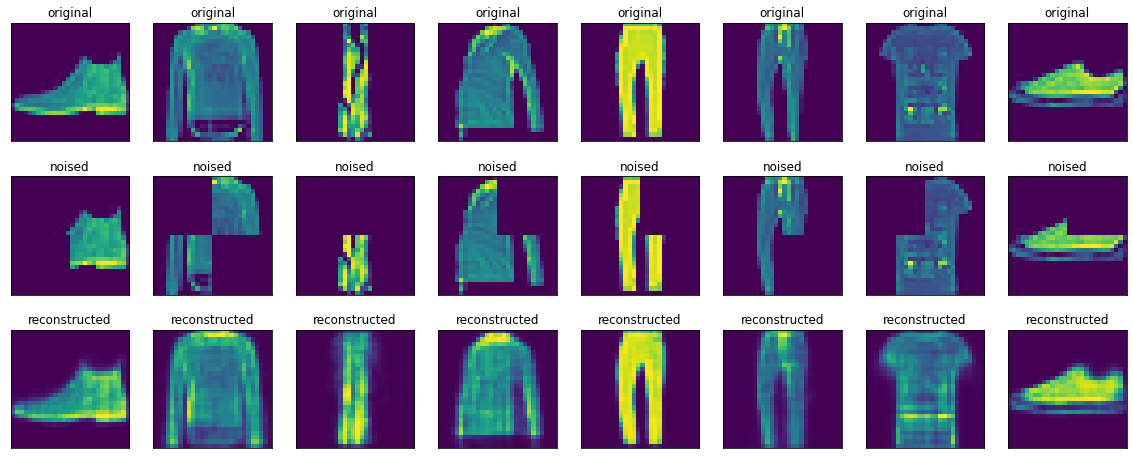

In [39]:
run_grid_search(experiment_id = 11, checkpoints_dir = "/content/drive/MyDrive/2_checkpoints")

In [41]:
import pprint

results_dir = "/content/drive/MyDrive/2_results"

path_to_results = os.path.join(results_dir, '10')

# Load the experiment data file
with open(path_to_results, 'r', encoding='utf-8') as f:
  test = json.load(f)

pprint.pprint(test, width=100)

{'best_hyperparams': [{'batch_size': 16,
                       'best_val_loss': 0.008751891190558672,
                       'decoder_units': [550],
                       'done': 1,
                       'encoder_units': [550],
                       'epochs': 57,
                       'lr': 0.9,
                       'model_num': 0,
                       'momentum': 0.9,
                       'weight_decay': 0}]}


Epoch:0 | Training Loss:0.028844385182112454 | Validation Loss: 0.020115643881261348

Epoch:1 | Training Loss:0.01814957719196876 | Validation Loss: 0.016621066626906395

Epoch:2 | Training Loss:0.015748136271536352 | Validation Loss: 0.014880788712203503

Epoch:3 | Training Loss:0.014498063180595636 | Validation Loss: 0.014000866276025772

Epoch:4 | Training Loss:0.01358884355686605 | Validation Loss: 0.013431593501567841

Epoch:5 | Training Loss:0.013034735896190008 | Validation Loss: 0.012802890967577696

Epoch:6 | Training Loss:0.012463200538232922 | Validation Loss: 0.01238092618882656

Epoch:7 | Training Loss:0.012121481247494618 | Validation Loss: 0.012073410221934318

Epoch:8 | Training Loss:0.01176522606536746 | Validation Loss: 0.011718453910946846

Epoch:9 | Training Loss:0.011488591600457827 | Validation Loss: 0.011521355556696653

Epoch:10 | Training Loss:0.011273205209771792 | Validation Loss: 0.011326352234184742

Epoch:11 | Training Loss:0.011046504857266942 | Validatio

<Figure size 432x288 with 0 Axes>

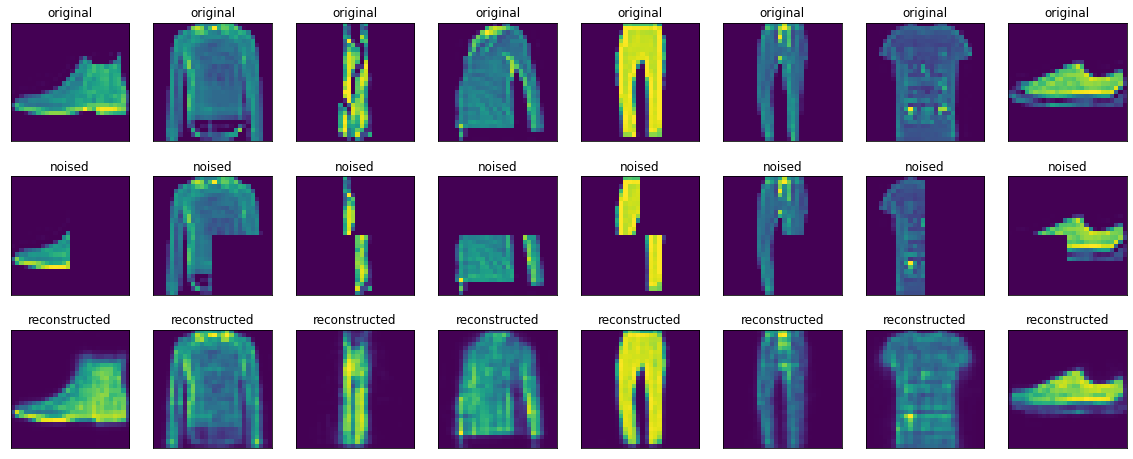

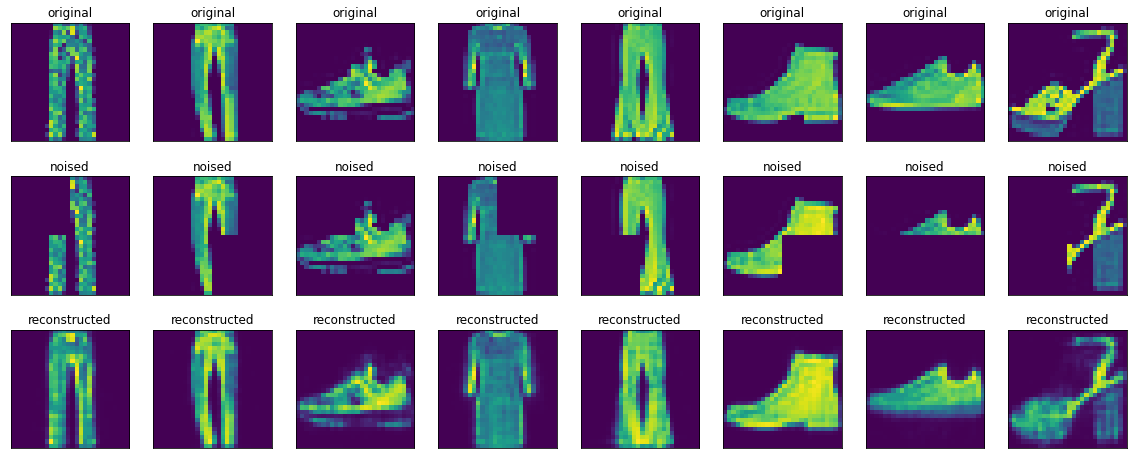

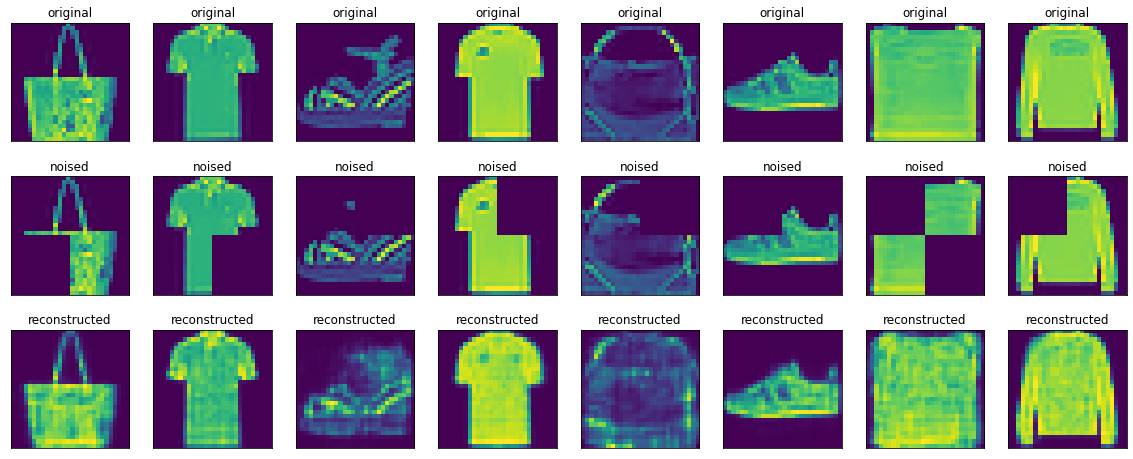

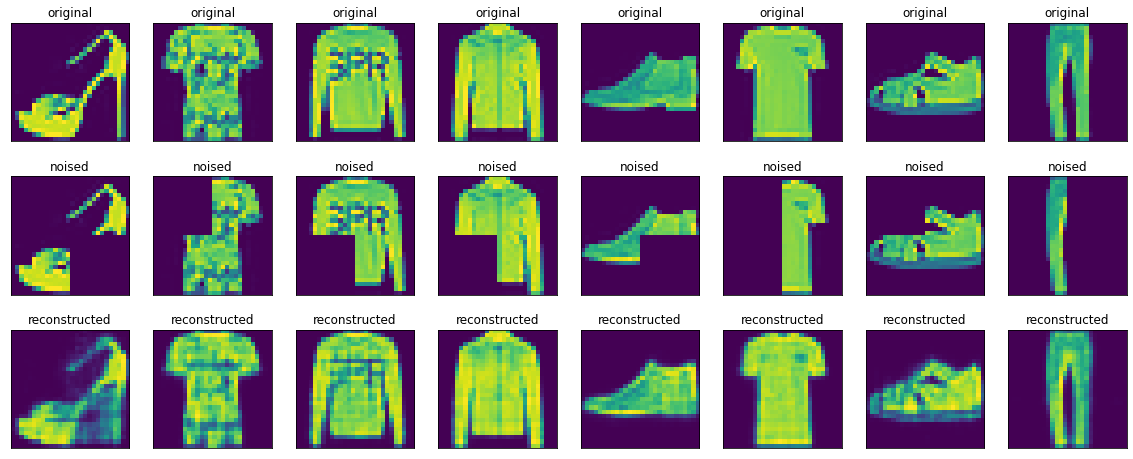

In [21]:
config = {'batch_size': 16,
                       'best_val_loss': 0.008751891190558672,
                       'decoder_units': [550],
                       'done': 1,
                       'encoder_units': [550],
                       'epochs': 57,
                       'lr': 0.9,
                       'model_num': 0,
                       'momentum': 0.9,
                       'weight_decay': 0}
results, best_results, plot_noise, plot_preds, plot_clean = train(config, epochs=60)
plot_image(plot_noise, plot_preds, plot_clean)

{'best_results': [{'batch_size': 64,
                   'best_val_loss': 0.04762743705302287,
                   'decoder_units': [32],
                   'done': 1,
                   'encoder_units': [32],
                   'epochs': 19,
                   'lr': 0.1,
                   'model_num': 14,
                   'momentum': 0.1,
                   'weight_decay': 0}]}

In [ ]:
# Store the grid and results in this dictionary
results = {
  'best_results': []
}

# This is the experiment path
path_to_save = os.path.join(checkpoints_dir, 'best_hyperparameters')

# We write the experiment dictionary as a .json file
with open(path_to_save, 'w', encoding='utf-8') as f:
  json.dump(results, f, ensure_ascii=False, indent=4)